In [2]:
import sys
sys.path.append(r'..')
import os
import numpy as np
import json
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import math
import statistics
import pickle as pkl
import torch
from expression_tree import simplify_equation, calc_r_squared, reward_func, BIC_np_calc_loss
from scipy import optimize

In [78]:
# Loading the dictionary
with open(os.getcwd() + "\\run_data\\Nguyen_12_Standard_0.pkl", 'rb') as file:
        results = pkl.load(file)

In [4]:
print(len(results["Ground Truth"]["Train"]))

KeyError: 'Train'

In [79]:
for key in results["Run Info"].keys():
    if key not in ["X", "Y"]:
        print(f"{key}: {results['Run Info'][key]}")

two_children_funcs: ['+', '-', '*', '/', '**']
one_children_funcs: ['np.log', 'np.sin', 'np.cos', 'np.sqrt', 'np.exp']
variables: ['x[0]', 'x[1]', '1', 'const']
epochs: 2000
max_depth: 32
epsilon: 0.05
entropy_coef: 0.005
batch: 1000
date: 2024-05-03 14:53:50.422966
inference_mode: False
model_type: BTSTransformerModel
model_parameters: {'max_depth': 32, 'transformer_device': 'cuda'}
optimizer_type: Adam
optimizer_parameters: {'lr': 0.0005, 'weight_decay': 0, 'opt_device': 'cpu'}


In [80]:
for key in results['Best Function'].keys(): 
    print(f'{key}: {results["Best Function"][key]}')
time_keys = ['Sample Time', 'Opt Time', 'Reward', 'Prediction']
print(f"Run Time: {round(sum([sum(results['Timings'][key]) for key in time_keys])/3600, 2)} hours")
equ = results["Best Function"]["Equation"]
if isinstance(results["Best Function"]["Constants"][0], float):
    results["Best Function"]["Constants"] = [[r] for r in results["Best Function"]["Constants"]]
for i, c in enumerate(results["Best Function"]["Constants"]):
    equ = equ.replace(f"c[{i}]", str(round(c[0], 3)))
equ = equ.replace("np.", "torch.")
simplified_equation = simplify_equation(equ, 0)
id_epoch = np.argmax(np.array([max(r) for r in results["Iteration Info"]["Rewards"]]))
print(f"Discovered Epoch: {id_epoch}")
print(f"Final Equation: {simplified_equation}")


Equation: ((((np.cos(((((1+c[0])-(c[1]*1))*((1-c[2])/(1**c[3])))/c[4])))-(np.cos((((x[1]-1)+c[5])-1))))*1)+(np.sin(c[6])))
Constants: [0.7082657672277707, 0.26104783636217227, 0.41036215506264584, 0.8479589054226389, 0.4731627677938845, 0.9901622315566371, 0.7580749151789482]
Loss: 0.8004598493647663
Simplified Equation: torch.sin(c[6]) + torch.cos((c[2] - 1)*(c[0] - c[1] + 1)/c[4]) - torch.cos(c[5] + x[1] - 2)
Run Time: 1.05 hours
Discovered Epoch: 1266
Final Equation: 0.455473899956166 - torch.cos(x[1] - 1.01)


In [19]:
device = torch.device("cpu")
x = np.array(results["Run Info"]["X"])
c = np.array(results["Best Function"]["Constants"])
y_pred = torch.tensor(eval(results["Best Function"]["Equation"].replace("torch.", "np.")))
y_real = torch.tensor(results["Run Info"]["Y"])
v = torch.mean((y_pred - y_real) ** 2)
sample_size = len(y_real)
MSE = torch.mean((y_pred - y_real)**2)
loss = -BIC_calc_loss(c, v, 3, x, y_real, results["Best Function"]["Equation"])
r_squared = 1 - torch.sum((y_pred - y_real)**2)/torch.sum((y_real - torch.mean(y_real))**2)
reward = reward_func(y_pred.numpy(), y_real.numpy(), y_real.std())

print("Training Data")
print(f"R2: {r_squared}")
print(f"Reward: {reward}")
print(f"MSE: {MSE}")
print(f"Loss: {loss}")

NameError: name 'BIC_calc_loss' is not defined

In [20]:
test_df = results["Ground Truth"]["Test"]
test_x = test_df.drop(["target"], axis=1).to_numpy().T
x = test_x
c = np.array(results["Best Function"]["Constants"])
y_pred = torch.tensor(eval(equ.replace("torch", "np")))
y_real = torch.tensor(test_df["target"].to_numpy())

v = torch.mean((y_pred - y_real) ** 2)
sample_size = len(y_real)
MSE = torch.mean((y_pred - y_real)**2)
loss = -BIC_calc_loss(c, v, len(results["Best Function"]["Constants"]), x, y_real, results["Best Function"]["Equation"])
r_squared = 1 - torch.sum((y_pred - y_real)**2)/torch.sum((y_real - torch.mean(y_real))**2)
reward = reward_func(y_pred.numpy(), y_real.numpy(), y_real.std())

print("Test Data")
print(f"R2: {r_squared}")
print(f"Reward: {reward}")
print(f"MSE: {MSE}")
print(f"Loss: {loss}")

KeyError: 'Test'

In [21]:
np.argwhere(np.isinf(y_pred.numpy()))

array([], shape=(0, 1), dtype=int64)

In [22]:
# # x = torch.cat([torch.linspace(1, 5, 100).unsqueeze(0), torch.ones(100).unsqueeze(0)*5, torch.ones(100).unsqueeze(0)*5], dim=0)
# # x = torch.linspace(0, 4, 100).unsqueeze(0)
# # x = eval(results["Ground Truth"]["Dataset"]).unsqueeze(0)
# c = torch.tensor(results["Best Function"]["Constants"])
# y_pred = eval(results["Best Function"]["Equation"])
# # c = torch.tensor(results["Ground Truth"]["c"])
# y_real = eval(results["Ground Truth"]["Function"])

# # Plotting
# plt.figure(figsize=(8, 6))
# plt.plot(x[0], y_real, label="Ground Truth", color='blue')
# plt.plot(x[0], y_pred, label="Best Function", linestyle='dashed', color='red')

# plt.title("Comparison between Best Function and Ground Truth")
# plt.scatter(results["Run Info"]["X"], results["Run Info"]["Y"], label="Observed Data")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend()
# plt.grid(True)
# plt.show() 

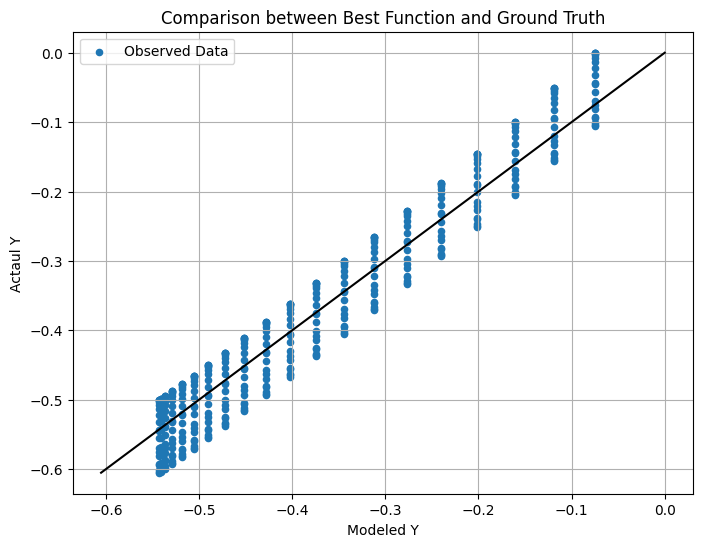

In [46]:
# Plotting
plt.figure(figsize=(8, 6))
plt.title("Comparison between Best Function and Ground Truth")
plt.scatter(y_pred, y_real, label="Observed Data", s=20)
x = np.linspace(min(y_real), max(y_real), 100)
X = np.linspace(min(y_real), max(y_real), 100)
plt.plot(X, X, color="black")
plt.xlabel("Modeled Y")
plt.ylabel("Actaul Y")
plt.legend()
plt.grid(True)
plt.show() 

In [81]:
all_losses = [item["Reward"] for item in list(results["All Equations Tested"].values())]
all_losses.sort(reverse=True)
top_10 = all_losses[:10]
temp_equ = list(results["All Equations Tested"].keys())
temp_rewards = [item["Reward"] for item in list(results["All Equations Tested"].values())]
for loss in top_10:
    ind = temp_rewards.index(loss)
    equ = temp_equ[ind]
    del temp_equ[ind]
    del temp_rewards[ind]
    R2 = results["All Equations Tested"][equ]["R2"]
    node_count = results["All Equations Tested"][equ]["Node Count"]
    print(f"Loss: {loss}, R2: {R2}, Node Count: {node_count}, Equ: {equ}")

Loss: 0.8004598493647663, R2: 0.937858521938324, Node Count: 32.0, Equ: ((((np.cos(((((1+c[0])-(c[1]*1))*((1-c[2])/(1**c[3])))/c[4])))-(np.cos((((x[1]-1)+c[5])-1))))*1)+(np.sin(c[6])))
Loss: 0.7944189578680451, R2: 0.9330320358276367, Node Count: 32.0, Equ: ((((c[0]**(np.sqrt(1)))/(c[1]+(np.sqrt((((c[2]+1)**x[0])*((1+x[1])-((c[3]+c[4])*(x[1]-c[5]))))))))+(c[6]-x[1]))-(np.cos(x[1])))
Loss: 0.7909473267307502, R2: 0.9301419854164124, Node Count: 32.0, Equ: ((((np.exp(c[0]))-(np.exp((x[1]-1))))*((((np.exp(c[1]))-1)-(np.cos(c[2])))-(np.sqrt((1**c[3])))))*(((np.log((c[4]*c[5])))-(x[1]-(np.exp(c[6]))))-c[7]))
Loss: 0.7877692197872478, R2: 0.9274197220802307, Node Count: 9.0, Equ: ((((np.sqrt(1))-(np.cos(x[1])))-c[0])-x[1])
Loss: 0.786492621376582, R2: 0.9263052940368652, Node Count: 32.0, Equ: (c[0]-((c[1]-((((c[2]+c[3])-1)-(np.cos(c[4])))-((c[5]-c[6])*c[7])))*((np.sqrt((1*x[1])))+(1-((np.cos(x[0]))**(1*c[8]))))))
Loss: 0.7830229078973754, R2: 0.9232145547866821, Node Count: 17.0, Equ: ((np.

In [82]:
all_r2s = np.array([item["R2"] for item in list(results["All Equations Tested"].values())])
all_r2s[np.isnan(all_r2s)] = -np.inf
all_r2s = list(all_r2s)
all_r2s.sort(reverse=True)
top_10 = all_r2s[:10]
for r2 in top_10:
    equ = list(results["All Equations Tested"].keys())[([item["R2"] for item in list(results["All Equations Tested"].values())]).index(r2)]
    R2 = results["All Equations Tested"][equ]["R2"]
    loss = results["All Equations Tested"][equ]["Reward"]
    node_count = results["All Equations Tested"][equ]["Node Count"]
    print(f"Loss: {loss}, R2: {R2}, Node Count: {node_count}, Equ: {equ}")

Loss: 0.8004598493647663, R2: 0.937858521938324, Node Count: 32.0, Equ: ((((np.cos(((((1+c[0])-(c[1]*1))*((1-c[2])/(1**c[3])))/c[4])))-(np.cos((((x[1]-1)+c[5])-1))))*1)+(np.sin(c[6])))
Loss: 0.7944189578680451, R2: 0.9330320358276367, Node Count: 32.0, Equ: ((((c[0]**(np.sqrt(1)))/(c[1]+(np.sqrt((((c[2]+1)**x[0])*((1+x[1])-((c[3]+c[4])*(x[1]-c[5]))))))))+(c[6]-x[1]))-(np.cos(x[1])))
Loss: 0.7909473267307502, R2: 0.9301419854164124, Node Count: 32.0, Equ: ((((np.exp(c[0]))-(np.exp((x[1]-1))))*((((np.exp(c[1]))-1)-(np.cos(c[2])))-(np.sqrt((1**c[3])))))*(((np.log((c[4]*c[5])))-(x[1]-(np.exp(c[6]))))-c[7]))
Loss: 0.7877692197872478, R2: 0.9274197220802307, Node Count: 9.0, Equ: ((((np.sqrt(1))-(np.cos(x[1])))-c[0])-x[1])
Loss: 0.786492621376582, R2: 0.9263052940368652, Node Count: 32.0, Equ: (c[0]-((c[1]-((((c[2]+c[3])-1)-(np.cos(c[4])))-((c[5]-c[6])*c[7])))*((np.sqrt((1*x[1])))+(1-((np.cos(x[0]))**(1*c[8]))))))
Loss: 0.7830229078973754, R2: 0.9232145547866821, Node Count: 17.0, Equ: ((np.

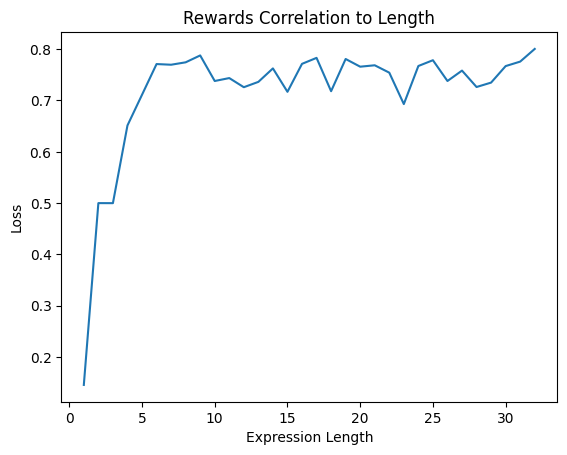

In [83]:
elements = list(results["All Equations Tested"].values())
best_reward = [-math.inf] * 64

for element in elements:
    if best_reward[int(element["Node Count"]) - 1] < element["Reward"]:
        best_reward[int(element["Node Count"]) - 1] = element["Reward"]
fig, ax = plt.subplots(1,1)
ax.plot(range(1, 65), best_reward)
ax.set_xlabel("Expression Length")
ax.set_ylabel("Loss")
ax.set_title("Rewards Correlation to Length")
plt.show()

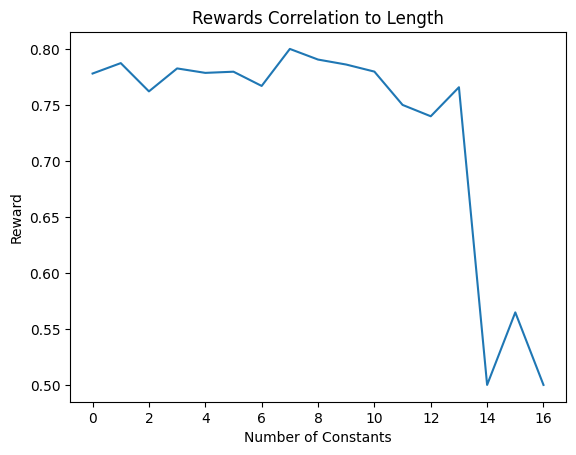

In [84]:
elements = [{"Equation": k, "Reward": v["Reward"]} for k, v in results["All Equations Tested"].items()]
best_reward = [-math.inf] * 32
for element in elements:
    index = element["Equation"].count('c[')
    if best_reward[index] < element["Reward"]:
        best_reward[index] = element["Reward"]
fig, ax = plt.subplots(1,1)
ax.plot(range(0, 32), best_reward)
ax.set_xlabel("Number of Constants")
ax.set_ylabel("Reward")
ax.set_title("Rewards Correlation to Length")
plt.show()

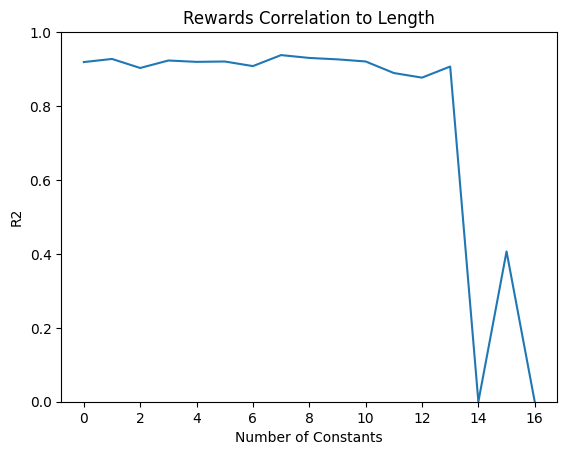

In [85]:
elements = [{"Equation": k, "R2": v["R2"]} for k, v in results["All Equations Tested"].items()]
best_reward = [-math.inf] * 32
for element in elements:
    try:
        index = element["Equation"].count('c[')
        if best_reward[index] < element["R2"]:
            best_reward[index] = element["R2"]
    except:
        print(element["Equation"])
fig, ax = plt.subplots(1,1)
ax.plot(range(0, 32), best_reward)
ax.set_xlabel("Number of Constants")
ax.set_ylabel("R2")
ax.set_ylim([0,1])
ax.set_title("Rewards Correlation to Length")
plt.show()

In [86]:
def smooth_data(data, window_size=5):
    # return [max(data[i:i+window_size]) for i in range(len(data)-window_size+1)]
    return [sum(data[i:i+window_size])/window_size for i in range(len(data)-window_size+1)]
window_size = math.ceil(len(results["Iteration Info"]["Loss"])/50)

In [87]:
for i, iter in enumerate(results["Iteration Info"]["Rewards"]):
    results["Iteration Info"]["Rewards"][i] = [j for j in iter if j > -1E32]
results["Iteration Info"]["Rewards"] = [np.array(r)[~np.isnan(r)] for r in results["Iteration Info"]["Rewards"]]
results["Iteration Info"]["Rewards"] = [np.array(r)[np.isfinite(r)] for r in results["Iteration Info"]["Rewards"]]

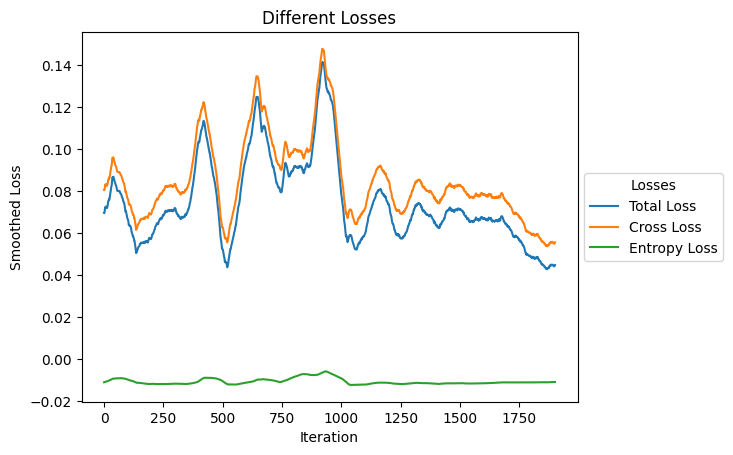

In [88]:
fig, ax = plt.subplots(1,1)
tmp = [-0.005 * temp.to(torch.device('cpu')) for temp in results["Iteration Info"]["Full Entropy"]]
window_size = 100
smoothed_loss = smooth_data(results["Iteration Info"]["Loss"], window_size)
ax.plot(range(len(smoothed_loss)), smoothed_loss, label="Total Loss")
ax.plot(range(len(smoothed_loss)), smooth_data(results["Iteration Info"]["Cross Loss"], window_size), label="Cross Loss")
ax.plot(range(len(smoothed_loss)), smooth_data(results["Iteration Info"]["Entropy Loss"], window_size), label="Entropy Loss")
# ax.plot(range(len(smoothed_loss)), smooth_data(tmp, window_size), label="Full Entropy")

# Adding labels and title
ax.set_xlabel("Iteration")
ax.set_ylabel("Smoothed Loss")
ax.set_title("Different Losses")

ax.legend(title="Losses", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.show()

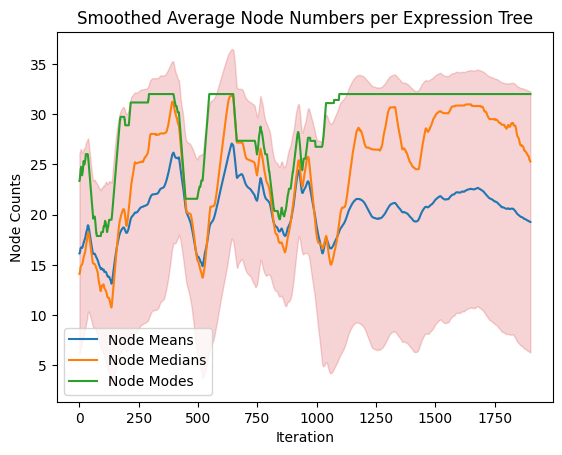

In [89]:
fig, ax = plt.subplots(1, 1)
node_means = [i.mean().to(torch.device("cpu")) for i in results["Iteration Info"]["Node Counts"]]
node_median = [i.median().to(torch.device("cpu")) for i in results["Iteration Info"]["Node Counts"]]
node_mode = [torch.mode(i.to(torch.device("cpu")))[0] for i in results["Iteration Info"]["Node Counts"]]
node_stds =  [i.std().to(torch.device("cpu")) for i in results["Iteration Info"]["Node Counts"]]

window_size = 100

# Plotting the Best Reward with smoothing
smoothed_node_means = smooth_data(node_means, window_size)
smoothed_node_median = smooth_data(node_median, window_size)
smoothed_node_mode = smooth_data(node_mode, window_size)
smoothed_node_stds = smooth_data(node_stds, window_size)

x = range(len(smoothed_node_means))
color = 'tab:red'
ax.plot(x, smoothed_node_means, label="Node Means")
ax.plot(x, smoothed_node_median, label="Node Medians")
ax.plot(x, smoothed_node_mode, label="Node Modes")
ax.fill_between(x, np.array(smoothed_node_means) - np.array(smoothed_node_stds),
                 np.array(smoothed_node_means) + np.array(smoothed_node_stds), color=color, alpha=0.2)

# Adding labels and title
ax.set_xlabel("Iteration")
ax.set_ylabel("Node Counts")
ax.set_title("Smoothed Average Node Numbers per Expression Tree")

# Adding legend
ax.legend()

# Show the plot
plt.show()

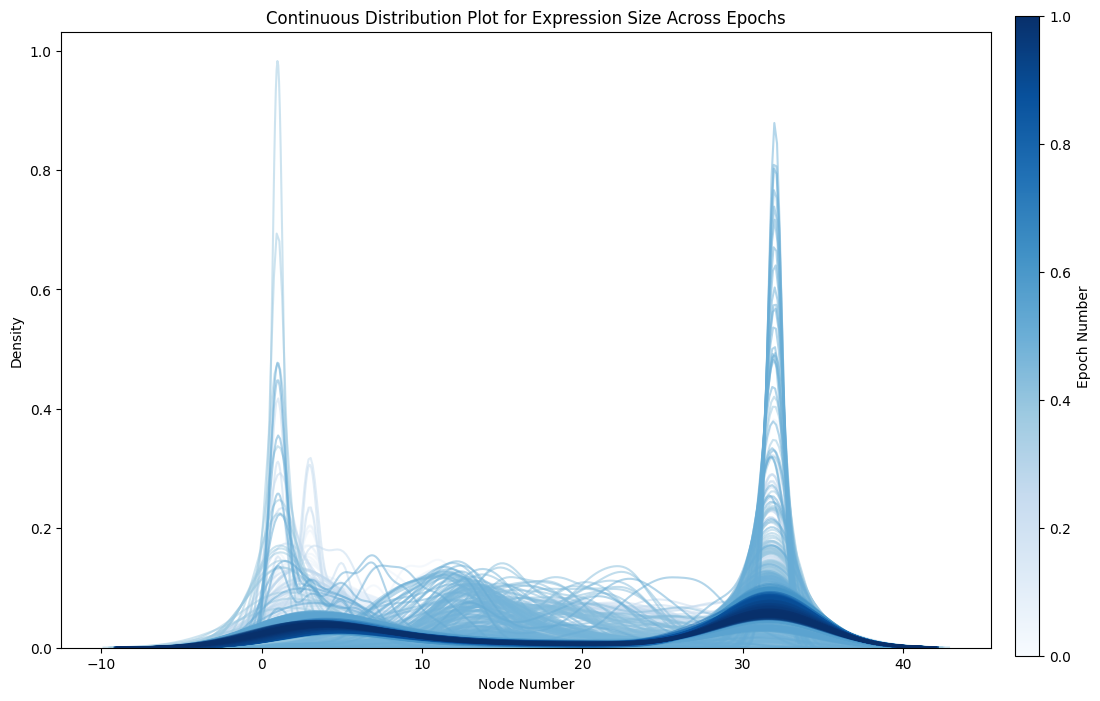

In [90]:
# Assuming 'results' is your data dictionary
node_nums = [i.to(torch.device("cpu")).numpy() for i in results["Iteration Info"]["Node Counts"]]
num_epochs = len(node_nums)

# Create a continuous distribution plot with lines for each epoch
plt.figure(figsize=(12, 8))

# Define a single color from the 'viridis' colormap
base_color = mpl.colormaps["Blues"]
    
for epoch_number, node_num_epoch in enumerate(node_nums):
    node_num_epoch = sorted(node_num_epoch, reverse=True)
    sns.kdeplot(node_num_epoch, color=base_color(epoch_number/num_epochs), fill=False, label='', alpha=0.5, warn_singular=False)
plt.xlabel("Node Number")
plt.ylabel("Density")
# plt.ylim(0, 15)
plt.title("Continuous Distribution Plot for Expression Size Across Epochs")

# Create a continuous legend using a color bar outside the plot
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position and size of the color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=base_color), cax=cax)

cbar.set_label('Epoch Number')

plt.show()

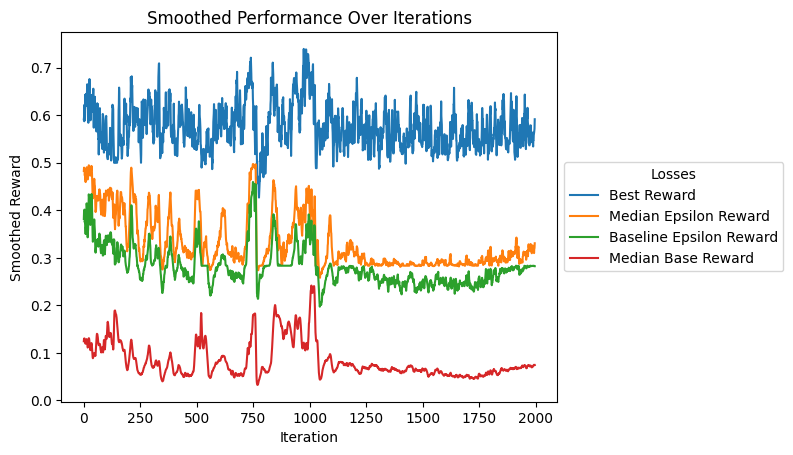

In [91]:
fig, ax = plt.subplots(1, 1)

# Plotting the Best Reward with smoothing
window_size = 5
smoothed_best_reward = smooth_data(results["Iteration Info"]["Best Reward"], window_size)
x = range(len(smoothed_best_reward))
# smoothed_best_reward = 1 / (1 + np.exp(-np.array(smoothed_best_reward)/100))
ax.plot(x, smoothed_best_reward, label="Best Reward")

# Plotting the Median Reward with smoothing
smoothed_median_reward = smooth_data(results["Iteration Info"]["Median Reward"], window_size)
# smoothed_median_reward = 1 / (1 + np.exp(-np.array(smoothed_median_reward)/100))
ax.plot(x, smoothed_median_reward, label="Median Epsilon Reward")

# Plotting the Baseline Reward with smoothing
smoothed_baseline_reward = smooth_data(results["Iteration Info"]["Baseline Reward"], window_size)
# smoothed_baseline_reward = 1 / (1 + np.exp(-np.array(smoothed_baseline_reward)/100))
ax.plot(x, smoothed_baseline_reward, label="Baseline Epsilon Reward")

smoothed_min_reward = smooth_data([np.mean(np.array(i)) for i in results["Iteration Info"]["Rewards"]], window_size)
# smoothed_min_reward = 1 / (1 + np.exp(-np.array(smoothed_min_reward)/100))
ax.plot(x, smoothed_min_reward, label="Median Base Reward")

# Adding labels and title
ax.set_xlabel("Iteration")
ax.set_ylabel("Smoothed Reward")
ax.set_title("Smoothed Performance Over Iterations")
# ax.set_xlim(0, 50)
# ax.set_ylim(-1000, 1000)
# Adding legend
ax.legend(title="Losses", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Show the plot
plt.show()

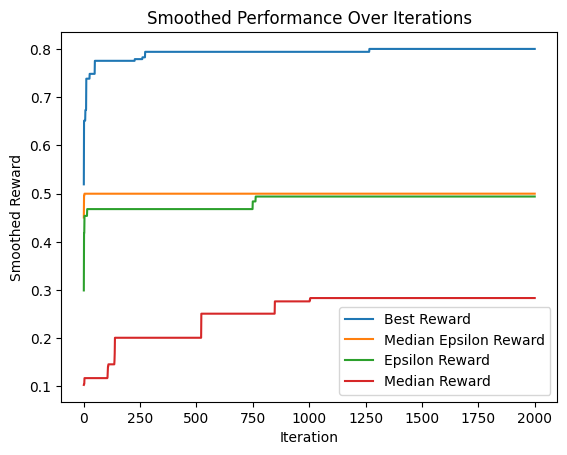

In [92]:
fig, ax = plt.subplots(1, 1)
cum_best = [-np.inf]
for i, r in enumerate(results["Iteration Info"]["Rewards"]):
    if max(r) > cum_best[-1]:
        cum_best.append(max(r))
    else:
        cum_best.append(cum_best[-1])

cum_epsilon_m = [-np.inf]
for i, r in enumerate(results["Iteration Info"]["Median Reward"]):
    if r > cum_epsilon_m[-1]:
        cum_epsilon_m.append(r)
    else:
        cum_epsilon_m.append(cum_epsilon_m[-1])
        
cum_epsilon = [-np.inf]
for i, r in enumerate(results["Iteration Info"]["Baseline Reward"]):
    if r > cum_epsilon[-1]:
        cum_epsilon.append(r)
    else:
        cum_epsilon.append(cum_epsilon[-1])
        
cum_median = [-np.inf]
for i, r in enumerate(results["Iteration Info"]["Rewards"]):
    if np.median(r) > cum_median[-1]:
        cum_median.append(np.median(r))
    else:
        cum_median.append(cum_median[-1])
        
# Plotting the Best Reward with smoothing
window_size = 1
smoothed_best_reward = smooth_data(cum_best, window_size)
x = range(len(smoothed_best_reward))
# smoothed_best_reward = 1 / (1 + np.exp(-np.array(smoothed_best_reward)/500))
ax.plot(x, smoothed_best_reward, label="Best Reward")


# Plotting the Epsilon Reward with smoothing
ax.plot(x, smooth_data(cum_epsilon_m, window_size), label="Median Epsilon Reward")

# Plotting the Epsilon Reward with smoothing
ax.plot(x, smooth_data(cum_epsilon, window_size), label="Epsilon Reward")

# Plotting the Median Reward with smoothing
ax.plot(x, smooth_data(cum_median, window_size), label="Median Reward")


# Adding labels and title
ax.set_xlabel("Iteration")
ax.set_ylabel("Smoothed Reward")
ax.set_title("Smoothed Performance Over Iterations")
# ax.set_xlim(0, 50)
# ax.set_ylim(-1000, 500)
# Adding legend
ax.legend()

# Show the plot
plt.show()

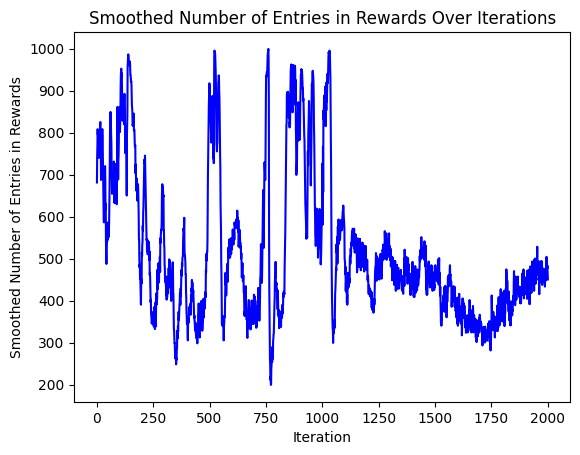

In [93]:
# Assuming 'results' is your data dictionary
temp_rewards = []
for i, iter in enumerate(results["Iteration Info"]["Rewards"]):
    temp_rewards.append([j for j in iter if j != 0])
rewards_entries = [len(entries) for entries in temp_rewards]
iterations = range(1, len(rewards_entries) + 1)

smoothed_entries = smooth_data(rewards_entries, window_size=1)

# Create a line plot with smoothing and without markers
plt.plot(iterations[len(iterations) - len(smoothed_entries):], smoothed_entries, linestyle='-', color='blue')

# Add labels and title
plt.xlabel("Iteration")
plt.ylabel("Smoothed Number of Entries in Rewards")
plt.title("Smoothed Number of Entries in Rewards Over Iterations")

# Show the plot
plt.show()

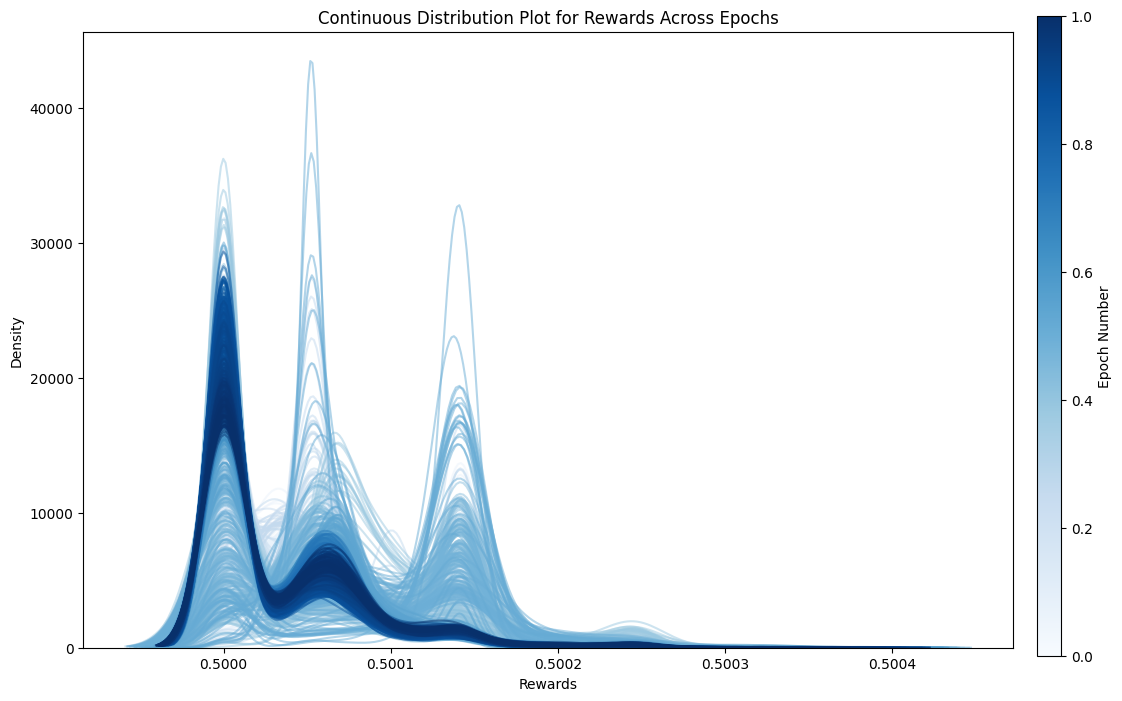

In [94]:
# Assuming 'results' is your data dictionary
np.seterr(over='ignore')
rewards_per_epoch = results["Iteration Info"]["Rewards"]
num_epochs = len(rewards_per_epoch)

# Create a continuous distribution plot with lines for each epoch
plt.figure(figsize=(12, 8))

# Define a single color from the 'viridis' colormap
base_color = mpl.colormaps["Blues"]
    
for epoch_number, rewards_for_single_epoch in enumerate(rewards_per_epoch):
    rewards_for_single_epoch = sorted(rewards_for_single_epoch, reverse=True)
    rewards_for_single_epoch = 1 / (1 + np.exp(-np.array(rewards_for_single_epoch)/500))
    sns.kdeplot(rewards_for_single_epoch, color=base_color(epoch_number/num_epochs), fill=False, label='', alpha=0.5, warn_singular=False)
plt.xlabel("Rewards")
plt.ylabel("Density")
plt.title("Continuous Distribution Plot for Rewards Across Epochs")

# Create a continuous legend using a color bar outside the plot
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position and size of the color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=base_color), cax=cax)

cbar.set_label('Epoch Number')

plt.show()

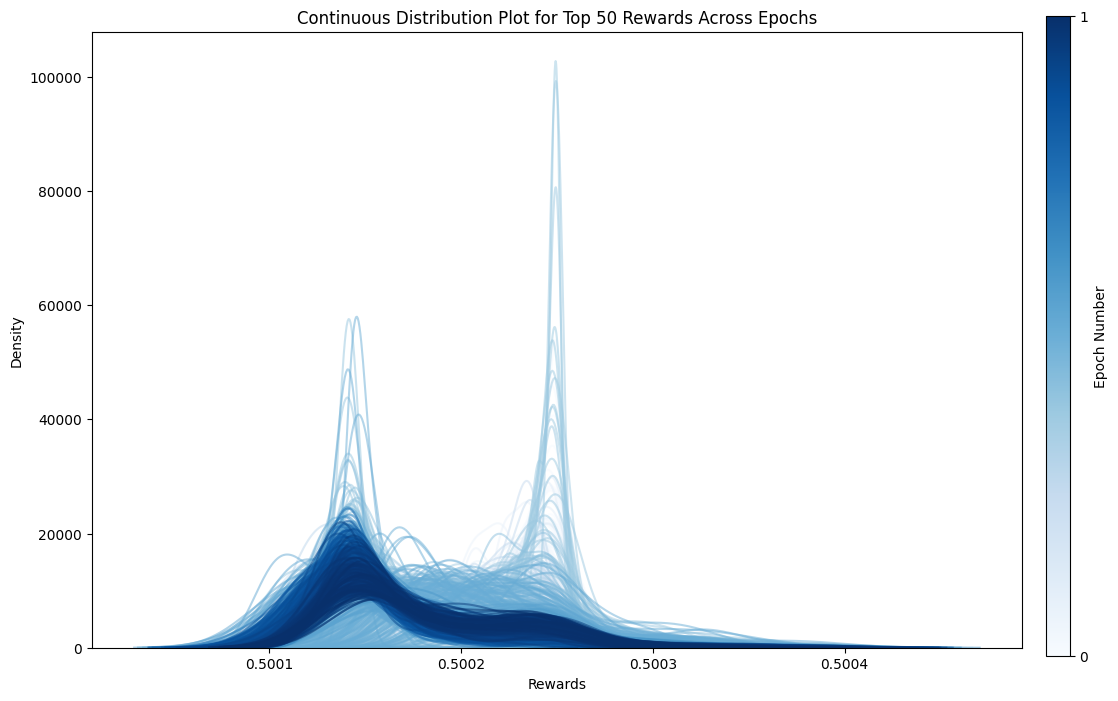

In [95]:
# Assuming 'results' is your data dictionary
rewards_per_epoch = results["Iteration Info"]["Rewards"]
num_epochs = len(rewards_per_epoch)
window_size = 1  # Set your desired window size

# Create a continuous distribution plot with lines for each epoch
plt.figure(figsize=(12, 8))

# Define a single color from the 'Blues' colormap
base_color = mpl.colormaps["Blues"]

for epoch_number, rewards_for_single_epoch in enumerate(rewards_per_epoch):
    rewards_for_single_epoch = sorted(rewards_for_single_epoch, reverse=True)[:50]
    rewards_for_single_epoch = 1 / (1 + np.exp(-np.array(rewards_for_single_epoch)/500))
    sns.kdeplot(rewards_for_single_epoch, color=base_color(epoch_number / num_epochs), fill=False, label=f'Epoch {epoch_number}', alpha=0.5, warn_singular=False)

plt.xlabel("Rewards")
plt.ylabel("Density")
# plt.ylim(0, 15)
plt.title("Continuous Distribution Plot for Top 50 Rewards Across Epochs")

# Create a continuous legend using a color bar outside the plot
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position and size of the color bar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=base_color), cax=cax, ticks=[0, 1])
cbar.set_label('Epoch Number')

plt.show()

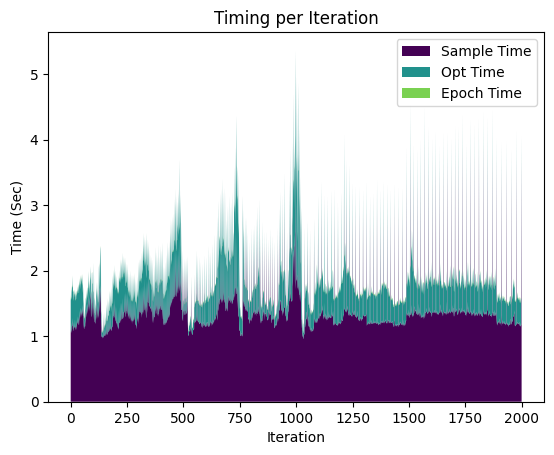

In [96]:
fig, ax = plt.subplots(1, 1)

smoothed_sample_time = smooth_data(results["Timings"]["Sample Time"], window_size)
smoothed_opt_time = smooth_data(results["Timings"]["Opt Time"], window_size)
smoothed_epoch_time = [smooth_data(results["Timings"]["Epoch Time"], window_size)[i] - smoothed_opt_time[i] - smoothed_sample_time[i] for i in range(len(smoothed_opt_time))]

# Choose a different colormap
colormap = mpl.colormaps['viridis']

# Creating a stacked area plot
ax.stackplot(range(len(smoothed_sample_time)), smoothed_sample_time, smoothed_opt_time, smoothed_epoch_time,
             labels=['Sample Time', 'Opt Time', 'Epoch Time'],colors=[colormap(0), colormap(0.5), colormap(0.8)])

# Adding labels and title
ax.set_xlabel("Iteration")
ax.set_ylabel("Time (Sec)")
ax.set_title("Timing per Iteration")
# Adding legend
ax.legend()

# Show the plot
plt.show()

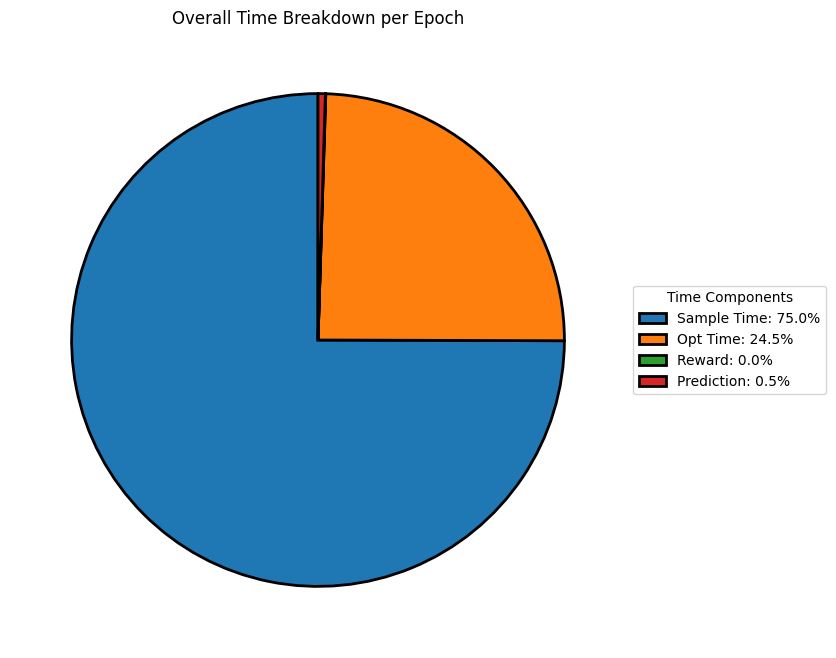

In [97]:
# Assuming 'results' is your data dictionary
time_keys = ['Sample Time', 'Opt Time', 'Reward', 'Prediction']

# Example data (replace this with your actual data)
time_values = [sum(results['Timings'][key]) for key in time_keys]
time_values = [100 * v/sum(time_values) for v in time_values]

fig, ax = plt.subplots(figsize=(8, 8))

# Creating a pie chart with black lines separating sections
wedges, texts, autotexts = ax.pie(time_values, labels=None, autopct='', startangle=90, wedgeprops=dict(linewidth=2, edgecolor='black'))

# Creating a legend with labeled percents
legend_labels = [f"{key}: {time:.1f}%" for key, time in zip(time_keys, time_values)]
ax.legend(wedges, legend_labels, title="Time Components", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Adding title
ax.set_title("Overall Time Breakdown per Epoch")

# Show the plot
plt.show()


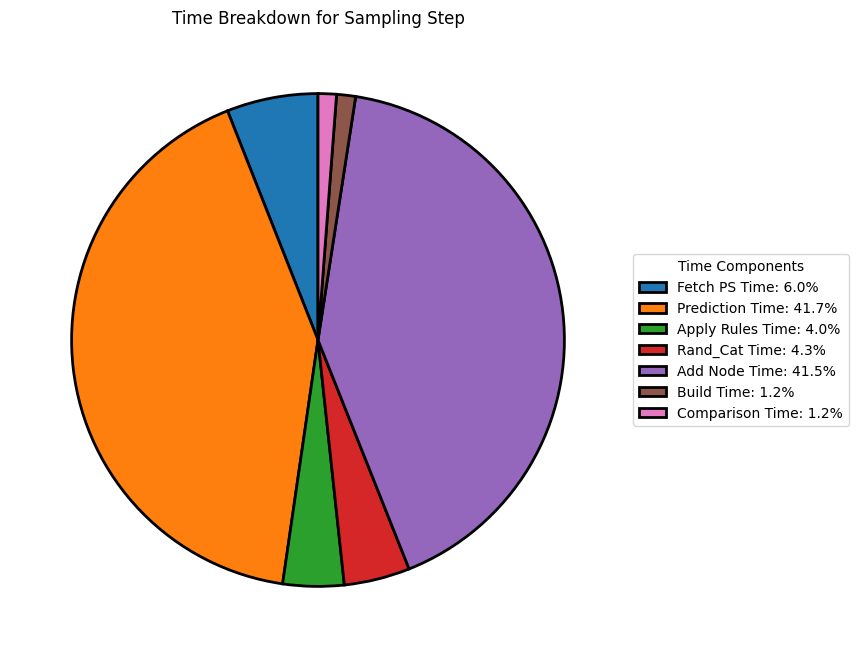

In [98]:
# Assuming 'results' is your data dictionary
time_keys = results['Timings']["Sample Time In-depth"][0].keys()
sample_timings = {}
for key in time_keys:
    sample_timings[key] = sum([results['Timings']["Sample Time In-depth"][k][key] for k in range(len(results['Timings']["Sample Time In-depth"]))])
sample_timings = (sample_timings.values())
sample_timings = [100 * v/sum(sample_timings) for v in sample_timings]

fig, ax = plt.subplots(figsize=(8, 8))

# Creating a pie chart with black lines separating sections
wedges, texts, autotexts = ax.pie(sample_timings, labels=None, autopct='', startangle=90, wedgeprops=dict(linewidth=2, edgecolor='black'))

# Creating a legend with labeled percents
legend_labels = [f"{key}: {time:.1f}%" for key, time in zip(time_keys, sample_timings)]
ax.legend(wedges, legend_labels, title="Time Components", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Adding title
ax.set_title("Time Breakdown for Sampling Step")

# Show the plot
plt.show()


In [99]:
x = np.array(results["Run Info"]["X"])
y = np.array(results["Run Info"]["Y"])
equ = results["Best Function"]["Equation"]
const_count = len(results["Best Function"]["Constants"])
const = np.random.rand(const_count)
def func(c):
    return y - eval(equ)

info = optimize.least_squares(func, const, method='lm')
const = info.x
v = np.mean((eval(equ) - y) ** 2)
loss = BIC_np_calc_loss(const, v, const_count, 26, x, y, equ)

IndexError: list index out of range

In [ ]:
c = const
y_pred = np.array(eval(equ))
y_real = np.array(results["Run Info"]["Y"])
sample_size = len(y_real)
MSE = np.mean((y_pred - y_real)**2)
loss = -BIC_np_calc_loss(c, v, const_count, 26, x, y_real, results["Best Function"]["Equation"])
r_squared = 1 - np.sum((y_pred - y_real)**2)/np.sum((y_real - np.mean(y_real))**2)
reward = reward_func(y_pred, y_real, y_real.std())

print("Training Data")
print(f"R2: {r_squared}")
print(f"Reward: {reward}")
print(f"MSE: {MSE}")
print(f"Loss: {loss}")

In [ ]:
test_df = results["Ground Truth"]["Test"]
test_x = test_df.drop(["target"], axis=1).to_numpy().T
x = test_x

y_pred = np.array(eval(equ))
y_real = test_df["target"].to_numpy()

sample_size = len(y_real)
MSE = np.mean((y_pred - y_real)**2)
loss = -BIC_np_calc_loss(c, v, len(results["Best Function"]["Constants"]), 26, x, y_real, equ)
r_squared = 1 - np.sum((y_pred - y_real)**2)/np.sum((y_real - np.mean(y_real))**2)
reward = reward_func(y_pred, y_real, y_real.std())

print("Test Data")
print(f"R2: {r_squared}")
print(f"Reward: {reward}")
print(f"MSE: {MSE}")
print(f"Loss: {loss}")

In [ ]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [49]:
get_size(results)

180574259

In [212]:
for key in results["Run Info"].keys():
    print(f"{key}: {get_size(results['Run Info'][key])}")

X: 17199680
Y: 2457080
two_children_funcs: 371
one_children_funcs: 396
variables: 627
epochs: 28
max_depth: 28
epsilon: 24
entropy_coef: 24
batch: 28
date: 75
inference_mode: 28
model_type: 68
model_parameters: 438
optimizer_type: 53
optimizer_parameters: 503


In [213]:
for key in results.keys():
    print(f"{key}: {get_size(results[key])}")

Best Function: 1651
Timings: 1393493
Iteration Info: 65224493
All Equations Tested: 919493865
Run Info: 19660953
Ground Truth: 24030373
